<a href="https://colab.research.google.com/github/swanny0000/ZTM-TensorFlow/blob/master/03_convolutional_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

What are conputer vision problems?
* Binary classification - is this pizza or steak?
* Multi-class classification - is this sushi, steak, or pizza?
* Object detection - where is the thing in here?

Let's take a look at a pizza_steak dataset and use a convolutional neural network to evaluate that binary classification problem, and then get into some fun...

---

BUT WAIT! What's a Convolutional Neural Network?
1. Just like neural networks, a CNN has a set of inputs (often pictures) and an input layer designed to ingest an input
2. CNNs have *convolution layers* intended to extract important features from an input. These can be 1-dimensional, 2-dimensional, or 3-dimensional convolutions, depending on the data you're dealing with (text, images, or 3D maps)
3. CNNs also have a *pooling layer* to reduce the dimensionality of our model features. E.g. the convolutional layers expand out the features, and the pooling layer identifies the most important features that have been identified.
4. CNNs then use one or more fully-connected output layers "Dense" to prepare the model to output it's prediction.

Note that CNNs have a WHOLE bunch of options when designing the model - stacks of convolutional and pooling layers on top of each other can widely impact the accuracy of the model.


In [1]:
# Let's get cracking
# Subset of food pictures from https://www.kaggle.com/datasets/dansbecker/food-101
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()


--2023-11-06 02:51:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  22.4MB/s    in 5.8s    

2023-11-06 02:51:55 (18.0 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



Look at our folder - we've got a pizza_steak folder with subfolders:
* test
  * pizza
  * steak
* train
  * pizza
  * steak

We'll start small, and eventually grow our model to incorporate more food types

In [2]:
# Let's inspect our data

!ls pizza_steak

test  train


In [3]:
# want through pizza_steak directory and count number of files
import os

for dirpath, dirnames, fnames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(fnames)} files in {dirpath}")

There are 2 directories and 0 files in pizza_steak
There are 2 directories and 0 files in pizza_steak/train
There are 0 directories and 750 files in pizza_steak/train/steak
There are 0 directories and 750 files in pizza_steak/train/pizza
There are 2 directories and 0 files in pizza_steak/test
There are 0 directories and 250 files in pizza_steak/test/steak
There are 0 directories and 250 files in pizza_steak/test/pizza


In [4]:
# let's create class names dynamically
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['pizza', 'steak'], dtype='<U5')

Image shape: (384, 512, 3)


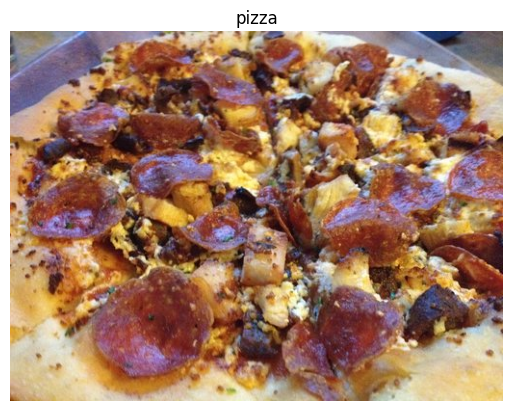

In [5]:
# let's visualize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")
  print(f"Image shape: {img.shape}")
  return img

img = view_random_image("pizza_steak/train/", "pizza")

Image shape: (512, 512, 3)


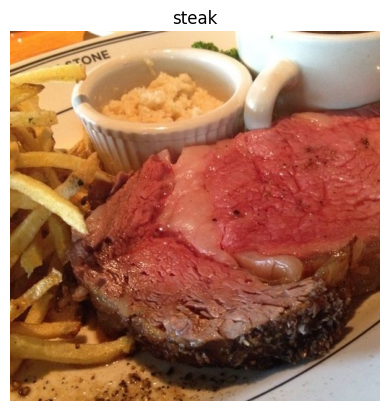

In [6]:
img = view_random_image("pizza_steak/train/", "steak")

Interesting... not all images are the same shape. How will we deal with that?

Also, these are RGB pictures - we'll need to normalize our data!

## An End-to-End Example
Let's:
1. Load our images into tensors
2. Preprocess our tensors
3. Build a CNN to find patterns in our tensors
4. Compile our CNN
5. Fit our CNN

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# set up paths to data directories
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"

# import data and turn them into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(224,224), # reshape our tensors to a standard size
                                               class_mode="binary",
                                               seed=42)
valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224,224), # reshape our tensors to a standard size
                                               class_mode="binary",
                                               seed=42)

# build a cnn!
model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.Conv2D(filters=10,
                                   kernel_size=3,
                                   activation="relu",
                                   input_shape=(224, 224, 3)))
model_1.add(tf.keras.layers.Conv2D(10, 3, activation="relu"))
model_1.add(tf.keras.layers.MaxPool2D(pool_size=2,
                                      padding="valid"))
model_1.add(tf.keras.layers.Conv2D(10, 3, activation="relu"))
model_1.add(tf.keras.layers.Conv2D(10, 3, activation="relu"))
model_1.add(tf.keras.layers.MaxPool2D(2))
model_1.add(tf.keras.layers.Flatten())
model_1.add(tf.keras.layers.Dense(1, activation="sigmoid"))

# compile the CNN
model_1.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer="Adam",
                metrics=["accuracy"])

# fit the CNN
history_1 = model_1.fit(train_data, #data and labels created automatically for us, thanks to the ImageDataGenerator
                        epochs=5,
                        steps_per_epoch=len(train_data), #47 batches of 32 images - this limits what the model looks at to save on RAM
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 22s 144ms/step - loss: 0.5753 - accuracy: 0.6987 - val_loss: 0.4336 - val_accuracy: 0.8080
Epoch 2/5
47/47 [==============================] - 6s 137ms/step - loss: 0.4524 - accuracy: 0.7873 - val_loss: 0.4144 - val_accuracy: 0.8000
Epoch 3/5
47/47 [==============================] - 7s 142ms/step - loss: 0.4363 - accuracy: 0.8140 - val_loss: 0.3823 - val_accuracy: 0.8660
Epoch 4/5
47/47 [==============================] - 6s 129ms/step - loss: 0.3807 - accuracy: 0.8327 - val_loss: 0.3367 - val_accuracy: 0.8560
Epoch 5/5
47/47 [==============================] - 6s 116ms/step - loss: 0.3486 - accuracy: 0.8540 - val_loss: 0.3530 - val_accuracy: 0.8500


note: if this is taking forever, turn on the GPUs!

CPU: `Epoch 1/5 47/47`
`[==============================] - 95s 2s/step`

GPU: `Epoch 1/5 47/47`
`[==============================] - 21s 162ms/step`


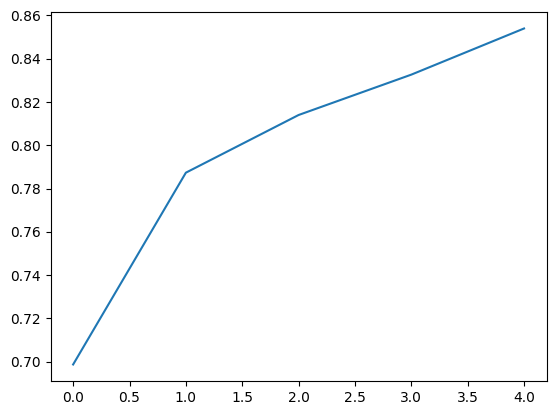

In [8]:
plt.plot(history_1.history["accuracy"])

In [9]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

we just created a CNN! how does it compare to https://poloclub.github.io/cnn-explainer/?

## Does a non-convolutional model work with image data?

Epoch 1/5
47/47 [==============================] - 6s 112ms/step - loss: 1.1934 - accuracy: 0.5020 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 6s 125ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 6s 127ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 5s 108ms/step - loss: 0.6932 - accuracy: 0.4787 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 7s 150ms/step - loss: 0.6932 - accuracy: 0.5040 - val_loss: 0.6931 - val_accuracy: 0.5000


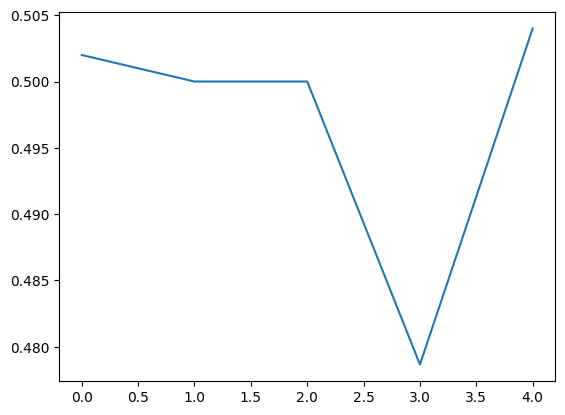

In [10]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Flatten(input_shape=(224, 224, 3)))
model_2.add(tf.keras.layers.Dense(4, activation="relu"))
model_2.add(tf.keras.layers.Dense(4, activation="relu"))
model_2.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model_2.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer="Adam",
                metrics=["accuracy"])

history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

plt.plot(history_2.history["accuracy"])

woof... not great. It's basically just guessing. How can we improve?

In [11]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 602116    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602141 (2.30 MB)
Trainable params: 602141 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


600k parameters vs a CNN's 30k parameters... but the CNN was much better!

Epoch 1/5
47/47 [==============================] - 8s 134ms/step - loss: 2.4547 - accuracy: 0.6340 - val_loss: 0.7249 - val_accuracy: 0.6640
Epoch 2/5
47/47 [==============================] - 8s 162ms/step - loss: 1.0362 - accuracy: 0.6653 - val_loss: 0.8021 - val_accuracy: 0.7540
Epoch 3/5
47/47 [==============================] - 6s 136ms/step - loss: 0.9251 - accuracy: 0.7267 - val_loss: 0.4840 - val_accuracy: 0.7980
Epoch 4/5
47/47 [==============================] - 5s 110ms/step - loss: 0.6113 - accuracy: 0.7367 - val_loss: 0.4362 - val_accuracy: 0.8000
Epoch 5/5
47/47 [==============================] - 7s 139ms/step - loss: 0.5892 - accuracy: 0.7560 - val_loss: 0.8365 - val_accuracy: 0.6000


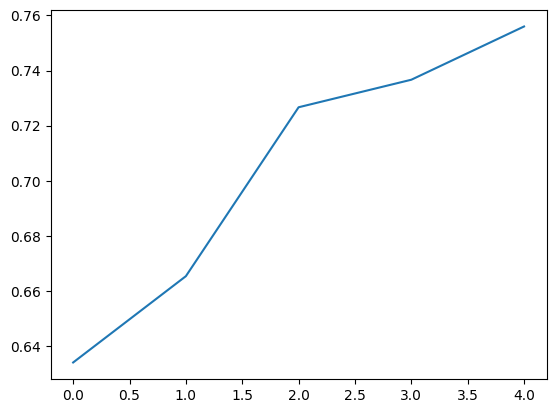

In [12]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Flatten(input_shape=(224, 224, 3)))
model_3.add(tf.keras.layers.Dense(100, activation="relu"))
model_3.add(tf.keras.layers.Dense(100, activation="relu"))
model_3.add(tf.keras.layers.Dense(100, activation="relu"))
model_3.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model_3.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer="Adam",
                metrics=["accuracy"])

history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

plt.plot(history_3.history["accuracy"])

ok... it's getting there... but still not great :(

In [13]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               15052900  
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15073201 (57.50 MB)
Trainable params: 15073201 (57.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


*and it took 15m parameters??* CNNs are a much better option for computer vision problems, even if a regular model will eventually learn patterns

## Let's break down Binary Classification

1. Become one with the data
2. Preprocess the data (scaling, normalizing, and batching)
3. Create a model (and start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust parameters to improve the model (to beat our baseline)
7. Repeat until satisfied

### Become one with the data

Image shape: (512, 512, 3)
Image shape: (382, 512, 3)


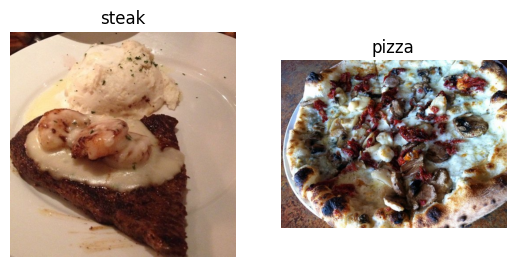

In [14]:
# Visualize!
plt. figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")

### Preprocess the data

In [15]:
from PIL import Image
# we're already got training and testing data
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

# turn our data into batches
#sinze these might be large images, the model can't take all of the images into memory at once
# trying to look at all of the images at once, rather than in smaller bits, could not result in very good learning rate
# common batch sizes are 16 or 32. DON"T GO ABOVE 32 (the guy who created these says it's bad for your health!)

# let's create train and test data generators and rescale teh data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [16]:
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode="binary",
                                             batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [17]:
# get a sample of the training dataset
images, labels = train_data.next() # get the "next" batch of images/labels
len(images), len(labels)

(32, 32)

In [18]:
# how many batches are there?
len(train_data)

47

In [19]:
# what do the image tnsors look like?
images[:2], images[0].shape

(array([[[[0.47058827, 0.40784317, 0.34509805],
          [0.48627454, 0.42352945, 0.36078432],
          [0.48627454, 0.43529415, 0.37254903],
          ...,
          [0.82745105, 0.7137255 , 0.48627454],
          [0.8431373 , 0.7372549 , 0.5294118 ],
          [0.87843144, 0.77647066, 0.58431375]],
 
         [[0.50980395, 0.427451  , 0.36078432],
          [0.5058824 , 0.42352945, 0.35686275],
          [0.5137255 , 0.4431373 , 0.3647059 ],
          ...,
          [0.82745105, 0.7058824 , 0.48235297],
          [0.82745105, 0.70980394, 0.49803925],
          [0.8431373 , 0.73333335, 0.5372549 ]],
 
         [[0.5254902 , 0.427451  , 0.34901962],
          [0.5372549 , 0.43921572, 0.36078432],
          [0.5372549 , 0.45098042, 0.36078432],
          ...,
          [0.82745105, 0.7019608 , 0.4784314 ],
          [0.82745105, 0.7058824 , 0.4901961 ],
          [0.8352942 , 0.7176471 , 0.5137255 ]],
 
         ...,
 
         [[0.77647066, 0.5647059 , 0.2901961 ],
          [0.77647

In [20]:
labels

array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

### Let's build a CNN!

Our baseline: relatively simple model or existing result that you try to beat as you develop your model

In [21]:
# there's an easier way to write our code...
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [22]:
# Create our model
model_4 = Sequential()
model_4.add(Conv2D(filters=10,
                   kernel_size=3,
                   strides=1,
                   padding="valid",
                   activation="relu",
                   input_shape=(224, 224, 3)))
model_4.add(Conv2D(10, 3, activation="relu"))
model_4.add(Conv2D(10, 3, activation="relu"))
model_4.add(Flatten())
model_4.add(Dense(1, activation="sigmoid"))
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_3 (Flatten)         (None, 475240)            0         
                                                                 
 dense_8 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477341 (1.82 MB)
Trainable params: 477341 (1.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


what's actually going on in those convolutional layers?
Conv2D
* Filters: how many filters/sliding windows should pass over an input tensor? Typical values 10, 32, 64, 128... the more you have, the more complex your model
* Kernel size: square of how big our filters are. lower values learn smaller feature, larger values learn larger features
* Strides: number of steps the filter takes across an image at a time. Typically 1 or 2. Can allow you to only retain the most important information.
* Padding: Pads the target tensor with zeroes (if "same") to preserve input shape, or lowers the output shape (if "valid") due to convolutional overlap at start and end. Typically, you want to use "same".

More info: https://poloclub.github.io/cnn-explainer/

In [24]:
# compile our model
model_4.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

### Fit our model!

In [25]:
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 10s 160ms/step - loss: 0.8472 - accuracy: 0.5687 - val_loss: 0.5232 - val_accuracy: 0.7320
Epoch 2/5
47/47 [==============================] - 6s 119ms/step - loss: 0.5338 - accuracy: 0.7580 - val_loss: 0.5013 - val_accuracy: 0.7700
Epoch 3/5
47/47 [==============================] - 6s 136ms/step - loss: 0.3985 - accuracy: 0.8333 - val_loss: 0.3793 - val_accuracy: 0.8620
Epoch 4/5
47/47 [==============================] - 8s 178ms/step - loss: 0.2401 - accuracy: 0.9200 - val_loss: 0.3795 - val_accuracy: 0.8300
Epoch 5/5
47/47 [==============================] - 6s 119ms/step - loss: 0.0941 - accuracy: 0.9727 - val_loss: 0.4828 - val_accuracy: 0.8020


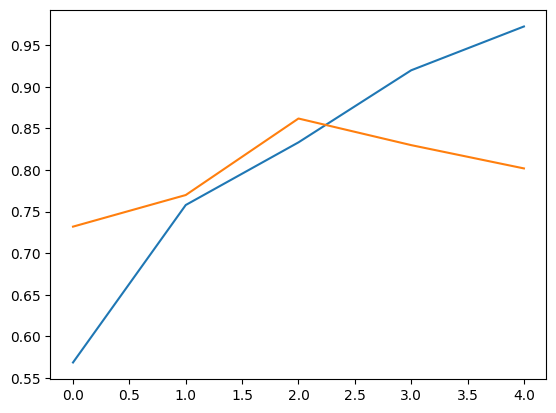

In [29]:
plt.plot(history_4.history["accuracy"])
plt.plot(history_4.history["val_accuracy"])

our training accuracy increase, but for some reason our test accuracy dropped a bit... what about our loss curves?

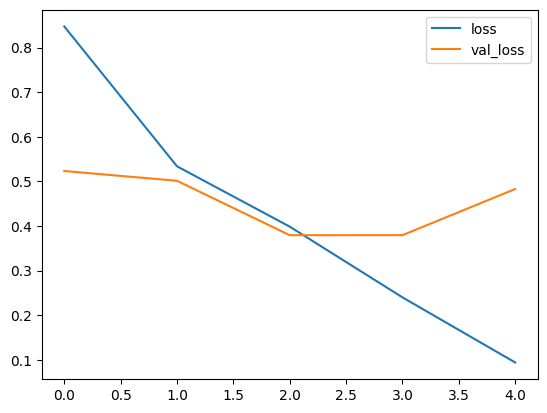

In [33]:
plt.plot(history_4.history["loss"], label="loss")
plt.plot(history_4.history["val_loss"], label="val_loss")
plt.legend()